In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skimage.feature import hog, daisy, local_binary_pattern
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [4]:
# Constants
TRAIN_IMAGES_DIR = 'train_ims/'
TRAIN_CSV = 'train.csv'
TEST_IMAGES_DIR = 'test_ims/'
TEST_CSV = 'test.csv'
IMG_SIZE = (32, 32)
SEED = 42  # For reproducibility

In [5]:
def load_data(csv_path, images_dir, augment=False):
    """Load images and optionally apply horizontal flip augmentation."""
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), desc="Loading images"):
        img_path = os.path.join(images_dir, row['im_name'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        label = row['label']
        
        images.append(img)
        labels.append(label)
        
        # Simple horizontal flip augmentation
        if augment:
            flipped_img = cv2.flip(img, 1)
            images.append(flipped_img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

def blur(img, kernel_size=4):
    """Blur image by averaging kernel_size x kernel_size blocks."""
    # Ensure image is in (height, width, channels) format
    if len(img.shape) == 3:  # Single image (H, W, C)
        h, w, c = img.shape
        # Reshape to (h//ks, ks, w//ks, ks, c) and average over kernel blocks
        blurred = np.mean(img.reshape(h//kernel_size, kernel_size, 
                                    w//kernel_size, kernel_size, c), 
                        axis=(1, 3))
        return blurred.flatten()
    else:
        raise ValueError("Input must be a 3D image array (H, W, C)")

def eoh(img, num_bins=9, cell_size=8):
    """Edge Orientation Histograms (EOH)."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) % (2 * np.pi)
    
    num_cells_x = gray.shape[1] // cell_size
    num_cells_y = gray.shape[0] // cell_size
    histograms = []
    
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            cell_mag = magnitude[i*cell_size:(i+1)*cell_size, 
                              j*cell_size:(j+1)*cell_size]
            cell_angle = angle[i*cell_size:(i+1)*cell_size, 
                              j*cell_size:(j+1)*cell_size]
            hist, _ = np.histogram(cell_angle, bins=num_bins, 
                                 range=(0, 2*np.pi), weights=cell_mag)
            histograms.append(hist)
    
    return np.concatenate(histograms)

def extract_features(images):
    """Extract HOG, LBP, Daisy, EOH, color stats, and blurred features."""
    hog_features = []
    lbp_features = []
    daisy_features = []
    eoh_features = []
    color_features = []
    blurred_features = []
    
    for img in tqdm(images, desc="Extracting features"):
        # Ensure image is in (H, W, C) format
        if len(img.shape) == 3 and img.shape[2] == 3:
            pass  # Already in correct format
        else:
            img = img.reshape(32, 32, 3)  # Reshape if needed
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # HOG
        hog_feat = hog(gray, orientations=8, pixels_per_cell=(4, 4), 
                      cells_per_block=(1, 1))
        hog_features.append(hog_feat)
        
        # LBP
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        hist_lbp, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))
        lbp_features.append(hist_lbp)
        
        # Daisy (on grayscale)
        daisy_feat = daisy(gray, step=7, radius=7, rings=1, 
                          histograms=6, orientations=8).flatten()
        daisy_features.append(daisy_feat)
        
        # EOH
        eoh_feat = eoh(img)
        eoh_features.append(eoh_feat)
        
        # Color stats (BGR and HSV)
        color_feat = []
        for channel in cv2.split(img):  # BGR
            color_feat.extend([np.mean(channel), np.std(channel)])
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        for channel in cv2.split(hsv):  # HSV
            color_feat.extend([np.mean(channel), np.std(channel)])
        color_features.append(color_feat)
        
        # Blurred (4x4 kernel)
        blurred_feat = blur(img)  # kernel_size=4 is now default
        blurred_features.append(blurred_feat)
    
    # Combine all features
    return np.hstack([
        np.array(hog_features),
        np.array(lbp_features),
        np.array(daisy_features),
        np.array(eoh_features),
        np.array(color_features),
        np.array(blurred_features)
    ])

class LDA_encoder:
    """LDA-based feature encoder (similar to the file's implementation)."""
    def __init__(self, n_components=9):
        self.lda = LinearDiscriminantAnalysis(n_components=n_components)
    
    def fit(self, X, y):
        self.lda.fit(X, y)
        self.class_centers = np.array([np.mean(self.lda.transform(X[y == i]), axis=0) for i in np.unique(y)])
    
    def encode(self, X):
        return 1 / np.array([np.linalg.norm(self.lda.transform(X) - center, axis=1) for center in self.class_centers]).T

In [ ]:
def main():
    # Load data with horizontal flip augmentation
    print("Loading data...")
    X, y = load_data(TRAIN_CSV, TRAIN_IMAGES_DIR, augment=True)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    # Extract features
    print("Extracting features...")
    X_train_feats = extract_features(X_train)
    X_val_feats = extract_features(X_val)
    print(f"Train features shape: {X_train_feats.shape}, Validation features shape: {X_val_feats.shape}")
    
    # Class balancing with SMOTE
    print("Balancing classes...")
    smote = SMOTE(random_state=SEED)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_feats, y_train)
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_val_scaled = scaler.transform(X_val_feats)
    
    # LDA encoding
    print("Applying LDA...")
    lda_encoder = LDA_encoder(n_components=9)
    lda_encoder.fit(X_train_scaled, y_train_balanced)
    X_train_encoded = np.hstack([X_train_scaled, lda_encoder.encode(X_train_scaled)])
    X_val_encoded = np.hstack([X_val_scaled, lda_encoder.encode(X_val_scaled)])
    
    # Train SVM (C=7 as requested)
    print("Training SVM...")
    svm = SVC(kernel='rbf', C=7, gamma='scale', random_state=SEED)
    svm.fit(X_train_encoded, y_train_balanced)
    
    # Validation
    val_preds = svm.predict(X_val_encoded)
    print(f"\nValidation Accuracy: {accuracy_score(y_val, val_preds):.4f}")
    print(classification_report(y_val, val_preds))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, val_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save model and scaler
    joblib.dump(svm, "svm_model.pkl")
    joblib.dump(scaler, "scaler.pkl")
    joblib.dump(lda_encoder, "lda_encoder.pkl")
    print("Models saved.")

Loading data...


Loading images: 50000it [00:07, 6665.02it/s]


Extracting features...


Extracting features: 100%|██████████| 20000/20000 [00:47<00:00, 421.04it/s]


Balancing classes...
Applying LDA...
Training SVM...

Validation Accuracy: 0.7720
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      2002
           1       0.85      0.88      0.87      1995
           2       0.68      0.66      0.67      1997
           3       0.59      0.63      0.61      2014
           4       0.72      0.73      0.73      1931
           5       0.69      0.66      0.68      1982
           6       0.83      0.80      0.82      1976
           7       0.82      0.80      0.81      2055
           8       0.88      0.88      0.88      1954
           9       0.87      0.83      0.85      2094

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



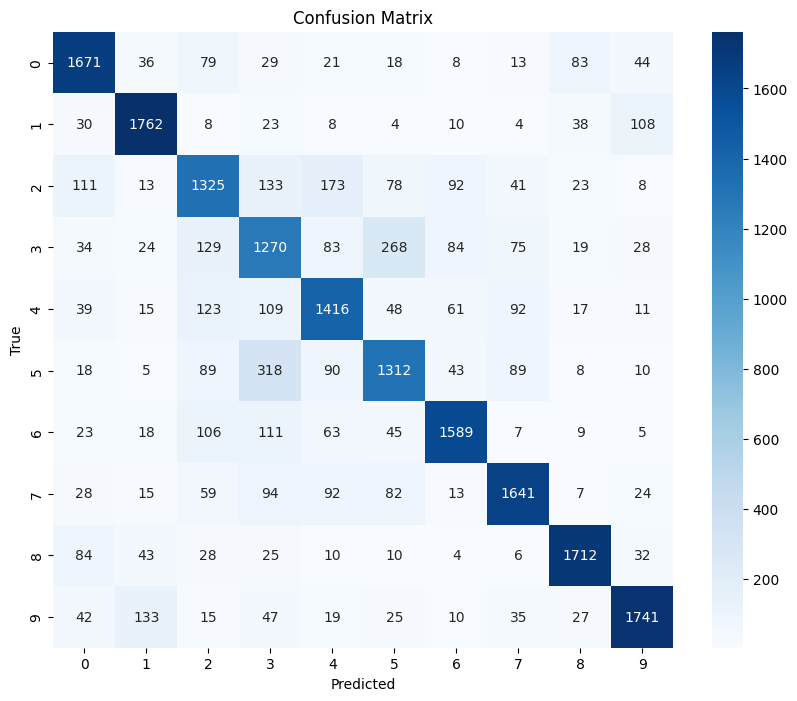

Models saved.
Loading test images...


100%|██████████| 10000/10000 [00:01<00:00, 8115.33it/s]



Extracting features...


  0%|          | 0/10000 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 96 into shape (32,32,3)

In [15]:
if __name__ == "__main__":
    main()

In [9]:
# Constants (match your training script)
TEST_IMAGES_DIR = 'test_ims/'
TEST_CSV = 'test.csv'
IMG_SIZE = (32, 32)

class LDA_encoder:
    """LDA-based feature encoder (same as in training)."""
    def __init__(self, n_components=9):
        self.lda = LinearDiscriminantAnalysis(n_components=n_components)
    
    def fit(self, X, y):
        self.lda.fit(X, y)
        self.class_centers = np.array([
            np.mean(self.lda.transform(X[y == i]), axis=0)
            for i in np.unique(y)
        ])
    
    def encode(self, X):
        return 1 / np.array([
            np.linalg.norm(self.lda.transform(X) - center, axis=1)
            for center in self.class_centers
        ]).T

# Load saved model and scalers
print("Loading saved models...")
svm = joblib.load("svm_model.pkl")
scaler = joblib.load("scaler.pkl")
lda_encoder = joblib.load("lda_encoder.pkl")

# Feature extraction functions (must match training)
def blur(img, kernel_size=4):
    """Blur image by averaging kernel_size x kernel_size blocks."""
    h, w, c = img.shape
    blurred = np.mean(img.reshape(h//kernel_size, kernel_size, 
                                w//kernel_size, kernel_size, c), 
                    axis=(1, 3))
    return blurred.flatten()

def eoh(img, num_bins=9, cell_size=8):
    """Edge Orientation Histograms."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) % (2 * np.pi)
    
    num_cells_x = gray.shape[1] // cell_size
    num_cells_y = gray.shape[0] // cell_size
    histograms = []
    
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            cell_mag = magnitude[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            cell_angle = angle[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            hist, _ = np.histogram(cell_angle, bins=num_bins, range=(0, 2*np.pi), weights=cell_mag)
            histograms.append(hist)
    
    return np.concatenate(histograms)

def extract_features(img):
    """Extract features for a single image (must match training)."""
    # Ensure proper shape
    if len(img.shape) == 3 and img.shape[2] == 3:
        pass
    else:
        img = img.reshape(IMG_SIZE[0], IMG_SIZE[1], 3)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # HOG
    hog_feat = hog(gray, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
    
    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    hist_lbp = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))[0]
    
    # Daisy
    daisy_feat = daisy(gray, step=7, radius=7, rings=1, histograms=6, orientations=8).flatten()
    
    # EOH
    eoh_feat = eoh(img)
    
    # Color stats
    color_feat = []
    for channel in cv2.split(img):  # BGR
        color_feat.extend([np.mean(channel), np.std(channel)])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    for channel in cv2.split(hsv):  # HSV
        color_feat.extend([np.mean(channel), np.std(channel)])
    
    # Blurred
    blurred_feat = blur(img)
    
    return np.hstack([hog_feat, hist_lbp, daisy_feat, eoh_feat, color_feat, blurred_feat])

def predict_test_images():
    """Main prediction function."""
    # Load test data
    test_df = pd.read_csv(TEST_CSV)
    test_images = []
    
    print("Loading test images...")
    for img_name in tqdm(test_df['im_name']):
        img_path = os.path.join(TEST_IMAGES_DIR, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        test_images.append(img)
    
    # Extract features
    print("\nExtracting features...")
    test_features = []
    for img in tqdm(test_images):
        features = extract_features(img)
        test_features.append(features)
    test_features = np.array(test_features)
    
    # Preprocess (scale + LDA)
    print("\nPreprocessing features...")
    test_scaled = scaler.transform(test_features)
    test_encoded = np.hstack([test_scaled, lda_encoder.encode(test_scaled)])
    
    # Predict
    print("\nMaking predictions...")
    predictions = svm.predict(test_encoded)
    
    # Save results
    test_df['label'] = predictions
    test_df.to_csv('predictions.csv', index=False)
    print("\nPredictions saved to predictions.csv")


Loading saved models...


In [10]:
if __name__ == "__main__":
    predict_test_images()

Loading test images...


100%|██████████| 10000/10000 [00:02<00:00, 3933.90it/s]



Extracting features...


100%|██████████| 10000/10000 [00:23<00:00, 420.14it/s]



Preprocessing features...

Making predictions...

Predictions saved to predictions.csv
